In [84]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : Symmetric Convolution


In [85]:
'''model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))'''

"model = VGG16(weights='imagenet',\n                  include_top=False,\n                  input_shape=(224, 224, 3))"

In [86]:
k = 20 # Top 10% highest l2-magnitude filters

(224, 224)


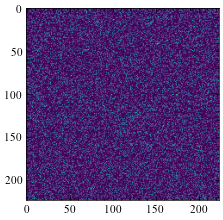

In [145]:
#var = 2/(128*9)

N = 224
img =  tf.math.maximum(0, tf.random.normal(shape=[N,N]))
#img =  tf.random.uniform(minval=0., maxval=1., shape=[N,N])

'''offset_height = (H - N) // 2
offset_width = (W - N) // 2
img = tf.image.crop_to_bounding_box(img, offset_height, offset_width, N, N)[...,0]'''
plt.imshow(img)
#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)

In [129]:
img

<tf.Tensor: shape=(224, 224), dtype=float32, numpy=
array([[0.2775805 , 0.4014207 , 0.01301551, ..., 0.45921314, 0.5931393 ,
        0.2084322 ],
       [0.38955188, 0.5081823 , 0.73343563, ..., 0.08296096, 0.2285738 ,
        0.02392709],
       [0.5530354 , 0.73561573, 0.39162564, ..., 0.79857004, 0.62877667,
        0.8542913 ],
       ...,
       [0.20621097, 0.44299757, 0.0675    , ..., 0.5074177 , 0.55394685,
        0.8713684 ],
       [0.6657059 , 0.17690897, 0.61279464, ..., 0.7821349 , 0.10838389,
        0.1747905 ],
       [0.8019575 , 0.5906013 , 0.6570742 , ..., 0.2530687 , 0.88641775,
        0.66833115]], dtype=float32)>

In [144]:

'''N = 45
img =  tf.expand_dims(cv2.imread('input4.png', 0)/255. , axis=-1)
H, W, C = img.shape  # Get image dimensions
offset_height = (H - N) // 2
offset_width = (W - N) // 2
img = tf.image.crop_to_bounding_box(img, offset_height, offset_width, N, N)[...,0]
plt.imshow(img)
#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)'''

"N = 45\nimg =  tf.expand_dims(cv2.imread('input4.png', 0)/255. , axis=-1)\nH, W, C = img.shape  # Get image dimensions\noffset_height = (H - N) // 2\noffset_width = (W - N) // 2\nimg = tf.image.crop_to_bounding_box(img, offset_height, offset_width, N, N)[...,0]\nplt.imshow(img)\n#img = (img-np.mean(img))/np.std(img)\n#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)\nprint(img.shape)"

X0 20194.305
X1 4653.9414
0
tf.Tensor(0.16666666666666674, shape=(), dtype=float64)
0.0007407398
1
tf.Tensor(0.16666666666666674, shape=(), dtype=float64)
0.0007397133
2
tf.Tensor(0.1666666666666667, shape=(), dtype=float64)
0.0007363715
3
tf.Tensor(0.16666666666666669, shape=(), dtype=float64)
0.0007307393
4
tf.Tensor(0.16666666666666669, shape=(), dtype=float64)
0.00072285614
5
tf.Tensor(0.1666666666666666, shape=(), dtype=float64)
0.0007127775
6
tf.Tensor(0.16666666666666669, shape=(), dtype=float64)
0.0007005766
7
tf.Tensor(0.16666666666666674, shape=(), dtype=float64)
0.00068634417
8
tf.Tensor(0.16666666666666674, shape=(), dtype=float64)
0.0006701882
9
tf.Tensor(0.1666666666666666, shape=(), dtype=float64)
0.00065223855
10
tf.Tensor(0.1666666666666667, shape=(), dtype=float64)
0.0006326481
11
tf.Tensor(0.16666666666666674, shape=(), dtype=float64)
0.00061159657
12
tf.Tensor(0.1666666666666667, shape=(), dtype=float64)
0.00058928406
13
tf.Tensor(0.1666666666666666, shape=(), dtype

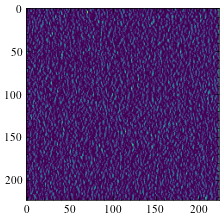

In [151]:
import matplotlib.patches as mpatches


w = np.zeros((3,3,1,1))
w[:,:,0,0] = (1/(6))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]])


x = img




directory = f"figures/malus"
if not os.path.exists(directory):
	os.makedirs(directory)


response_mag = []
init_mag = tf.math.reduce_euclidean_norm(x).numpy()

x = tf.cast(tf.expand_dims([img], axis=-1), dtype=tf.float32) 
print("X0" , tf.math.reduce_sum(x).numpy())


x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							 padding='SAME') )
plt.imshow(np.sum(x[0,:,:,:], axis=-1))

init_mag = tf.math.reduce_sum(img).numpy()

angles = np.linspace(-np.pi, np.pi, 100)


print("X1" , tf.math.reduce_sum(x).numpy())

for i in range(100):
	print(i)
	#fig, ax = plt.subplots()
	
	
	w[:,:,0,0] = (np.cos(angles[i]))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(angles[i]))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
	w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w[:,:,0,0])**2)
	print(tf.math.reduce_euclidean_norm(w[:,:,0,0])**2)
		
	x_out = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
								padding='SAME') )

	response_mag.append(tf.math.reduce_euclidean_norm(x_out).numpy()/init_mag)
	print(response_mag[-1])

	#im = ax.imshow(np.sum(x_out[0,:,:,:], axis=-1))
	#ax.plot(45//2, 45, marker = '+', color='red')



	#ax.set(xlim=(0, 45), ylim=(0, 45))
	#fig.colorbar(im, orientation='vertical')
	#fig.savefig(directory + f'/{i}.pdf', dpi=600,  transparent=True, bbox_inches='tight')




In [123]:
i=0
(np.cos(angles[i]))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]]) + ( np.sin(angles[i]))*np.array([[1,1,1], [0,0,0], [-1,-1,-1]])

array([[-1.0000000e+00, -1.2246468e-16,  1.0000000e+00],
       [-1.0000000e+00, -0.0000000e+00,  1.0000000e+00],
       [-1.0000000e+00,  1.2246468e-16,  1.0000000e+00]])

In [94]:
angles

array([-3.14159265, -3.07812614, -3.01465962, -2.9511931 , -2.88772658,
       -2.82426006, -2.76079354, -2.69732703, -2.63386051, -2.57039399,
       -2.50692747, -2.44346095, -2.37999443, -2.31652792, -2.2530614 ,
       -2.18959488, -2.12612836, -2.06266184, -1.99919533, -1.93572881,
       -1.87226229, -1.80879577, -1.74532925, -1.68186273, -1.61839622,
       -1.5549297 , -1.49146318, -1.42799666, -1.36453014, -1.30106362,
       -1.23759711, -1.17413059, -1.11066407, -1.04719755, -0.98373103,
       -0.92026451, -0.856798  , -0.79333148, -0.72986496, -0.66639844,
       -0.60293192, -0.53946541, -0.47599889, -0.41253237, -0.34906585,
       -0.28559933, -0.22213281, -0.1586663 , -0.09519978, -0.03173326,
        0.03173326,  0.09519978,  0.1586663 ,  0.22213281,  0.28559933,
        0.34906585,  0.41253237,  0.47599889,  0.53946541,  0.60293192,
        0.66639844,  0.72986496,  0.79333148,  0.856798  ,  0.92026451,
        0.98373103,  1.04719755,  1.11066407,  1.17413059,  1.23

In [95]:
w[:,:,0,0]

array([[-1.66666667e-01,  2.04107800e-17,  1.66666667e-01],
       [-1.66666667e-01,  0.00000000e+00,  1.66666667e-01],
       [-1.66666667e-01, -2.04107800e-17,  1.66666667e-01]])

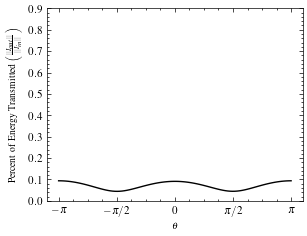

In [147]:
fig, ax= plt.subplots(1,1)

ax.plot(angles,response_mag)

ticks = np.arange(-np.pi, 1.5*np.pi, np.pi/2)
labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels);
ax.set_yticks(ticks=np.arange(0,1, 0.1));

ax.set_ylabel(r"Percent of Energy Transmitted $\left( \frac{||I_{out}||}{||I_{in}||} \right)$", fontsize=7)
ax.set_xlabel(r"$\theta$", fontsize=7)

plt.savefig('figures/malus.pdf', dpi=600)
plt.show()


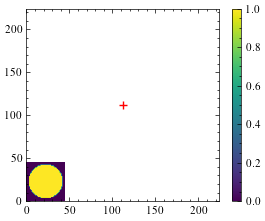

In [143]:
fig, ax= plt.subplots(1,1)


im = ax.imshow(img)
ax.plot(112, 112, marker = '+', color='red')



ax.set(xlim=(0, 224), ylim=(0, 224))

fig.colorbar(im, orientation='vertical')
fig.savefig(directory + f'/original.pdf', dpi=600,  transparent=True, bbox_inches='tight')


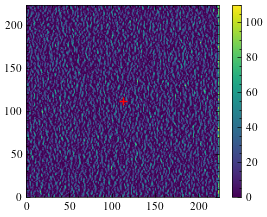

In [100]:
fig, ax= plt.subplots(1,1)


x = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = filters.shape[-2], axis=-1), dtype=tf.float32) 

w = np.zeros((3,3,1,1))
w[:,:,0,0] = (1/(6))*np.array([[1,0,-1], [1,0,-1], [1,0,-1]])

x = tf.nn.relu( tf.nn.conv2d(x, w , strides=(1,1), 
							 padding='SAME') )

im = ax.imshow(x[0,:,:,0])
ax.plot(112, 112, marker = '+', color='red')



ax.set(xlim=(0, 224), ylim=(0, 224))

fig.colorbar(im, orientation='vertical')
fig.savefig(directory + f'/reference.pdf', dpi=600,  transparent=True, bbox_inches='tight')

In [101]:
x

<tf.Tensor: shape=(1, 224, 224, 1), dtype=float32, numpy=
array([[[[ 0.       ],
         [ 0.       ],
         [24.535934 ],
         ...,
         [ 0.       ],
         [10.065212 ],
         [64.34762  ]],

        [[ 0.       ],
         [ 0.       ],
         [23.773489 ],
         ...,
         [ 0.       ],
         [ 5.841455 ],
         [64.4438   ]],

        [[ 0.       ],
         [ 3.6880114],
         [11.411099 ],
         ...,
         [ 0.       ],
         [ 0.       ],
         [63.310776 ]],

        ...,

        [[ 0.       ],
         [13.521972 ],
         [ 0.       ],
         ...,
         [ 0.       ],
         [98.428986 ],
         [89.800766 ]],

        [[ 0.       ],
         [ 5.1716905],
         [ 0.       ],
         ...,
         [ 0.       ],
         [58.61606  ],
         [93.54829  ]],

        [[ 0.       ],
         [ 9.653798 ],
         [ 0.       ],
         ...,
         [ 0.       ],
         [29.618204 ],
         [70.7091   ]]]], dty